In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX002"

adata = sc.read(f"../../segmentation/bin2cell/bin2cell_output_he0005_gex005/{sample_id}/adata_processed.h5ad")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata

In [ ]:
# Load the metadata
metadata = pd.read_csv("~/rawdata/IMMUNEX/data/VisiumHD_18_2024_NSCLC.csv")
display(metadata.sample())

metadata_sample = metadata[metadata['Sample_code'] == sample_id]
adata.uns["sample_metadata"] = metadata_sample.iloc[0].to_dict()

display(adata.obs.sample()) # Display the first few rows of the observation data (cell metadata)

## Seg. sources

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Boolean masks from adata
is_he = adata.obs['labels_he'] != 0
is_he_exp = adata.obs['labels_he_expanded'] != 0
is_gex = adata.obs['labels_gex'] != 0

# Hierarchical categorization
conditions = {
    "Shared": is_he_exp & is_gex,
    "HE (Nuclei) ": is_he & ~is_gex,
    "HE expansion only": is_he_exp & ~is_gex & ~is_he,
    "GEx only": is_gex & ~is_he_exp,
    "Unassigned": ~is_he_exp & ~is_gex
}

# Count bins in each category
counts = {k: v.sum() for k, v in conditions.items()}

# Create DataFrame
df = pd.DataFrame(list(counts.items()), columns=["Category", "Count"])
df["Percentage"] = df["Count"] / df["Count"].sum() * 100

# Ensure specific order
df["Category"] = pd.Categorical(df["Category"], categories=[
    "Shared", "HE (Nuclei) ", "HE expansion only", "GEx only", "Unassigned"
], ordered=True)
df = df.sort_values("Category")

# Define custom colors
colors = {
    "Shared": "#66c2a5",
    "HE (Nuclei) ": "#fc8d62",
    "HE expansion only": "#ffd92f",
    "GEx only": "#8da0cb",
    "Unassigned": "#dddddd"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
left = 0
for _, row in df.iterrows():
    ax.barh(y=0, width=row["Count"], left=left,
            color=colors[row["Category"]], label=row["Category"])
    ax.text(left + row["Count"]/2, 0,
            f"{int(row['Count'])}\n({row['Percentage']:.1f}%)",
            ha="center", va="center", fontsize=9, color="black")
    left += row["Count"]

ax.set_yticks([])
ax.set_xlabel("Number of Bins")
ax.set_title("Hierarchical Segmentation Overlap")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Filtering bins using segmentation results

In [ ]:
# Count bins per segmentation (excluding label 0 as background)
label_col = 'labels_joint'
adata_obs = adata.obs.copy()
cell_bin_counts = adata_obs[label_col].value_counts()
cell_bin_counts = cell_bin_counts[cell_bin_counts.index != 0]  # exclude background

# Plot distribution before filtering
plt.figure(figsize=(6, 4))
plt.hist(cell_bin_counts.values, bins=100, color='skyblue')
plt.axvline(np.percentile(cell_bin_counts.values, 99), color='red', linestyle='--', label='fltr. percentile')
plt.title("Cell Size Distribution from HE+GEx (Before Filtering)")
plt.xlabel("Number of Bins per Cell")
plt.ylabel("Cell Count")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Count bins per segmentation (excluding label 0 as background)
label_col = 'labels_he_expanded'
cell_bin_counts = adata_obs[label_col].value_counts()
cell_bin_counts = cell_bin_counts[cell_bin_counts.index != 0]  # exclude background

# Plot distribution before filtering
plt.figure(figsize=(6, 4))
plt.hist(cell_bin_counts.values, bins=100, color='skyblue')
plt.axvline(np.percentile(cell_bin_counts.values, 99), color='red', linestyle='--', label='90th percentile')
plt.title("Cell Size from HE (Before Filtering)")
plt.xlabel("Number of Bins per Cell")
plt.ylabel("Cell Count")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Filtering logic
threshold = np.percentile(cell_bin_counts.values, 99)
valid_labels = cell_bin_counts[cell_bin_counts <= threshold].index
mask = adata_obs[label_col].isin(valid_labels)

# New filtered counts
filtered_counts = adata_obs[mask][label_col].value_counts()

# Plot distribution after filtering
plt.figure(figsize=(6, 4))
plt.hist(filtered_counts.values, bins=100, color='lightgreen')
plt.title("Cell Size Distribution (After Filtering)")
plt.xlabel("Number of Bins per Cell")
plt.ylabel("Cell Count")
plt.tight_layout()
plt.show()


In [ ]:
print(adata)
z = {adata.obs['labels_joint'].isin(filtered_counts.index).value_counts()[False] / len(adata.obs)}
print(f'Filtered : {z}')
idx = adata.obs['labels_joint'].isin(filtered_counts.index).value_counts()

mask = adata.obs['labels_joint'].isin(filtered_counts.index)
adata_filtered = adata[mask].copy()
adata_filtered

## Group bins by segmentation

In [ ]:
adata_filtered.obs['cell_id'] = adata_filtered.obs['labels_joint'].astype(str)
adata_cells = adata_filtered[adata_filtered.obs['labels_joint'] > 0].copy()
adata_cells.var['mt'] = adata_cells.var_names.str.upper().str.startswith('MT-')

# Use CSR for efficient row slicing
X = adata_cells.X.tocsr()
cell_ids = adata_cells.obs['cell_id'].values
print('Analysing')

# Map cell_id to integer index
unique_ids, inverse_idx = np.unique(cell_ids, return_inverse=True)
n_cells = len(unique_ids)
n_genes = X.shape[1]
print('Analysing')

# Initialize empty matrix to store the result
# Result will be dense at the end, but small: (n_cells x n_genes)
result = np.zeros((n_cells, n_genes))
print('Analysing')

# Efficient sparse row-by-row summing
for i in tqdm(range(X.shape[0])):
    result[inverse_idx[i]] += X[i].toarray()[0]

# Convert to DataFrame
grouped_expr = pd.DataFrame(result, index=unique_ids, columns=adata_cells.var_names)



In [21]:

adata_cells = AnnData(X=sp.csr_matrix(grouped_expr.values))
adata_cells.obs_names = grouped_expr.index
adata_cells.var_names = grouped_expr.columns # Gene Names


In [22]:

# and 'cell_id' is the grouping key used to generate grouped_expr
# 1. Get a mapping from cell_id → average spatial position
cell_coords = adata_filtered.obs[['cell_id']].copy()
cell_coords['x'] = adata_filtered.obsm['spatial'][:, 0]
cell_coords['y'] = adata_filtered.obsm['spatial'][:, 1]

# 2. Average spatial position per cell
mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()

# 3. Match to your grouped_expr.index (cell IDs)
mean_coords = mean_coords.loc[grouped_expr.index]

# 4. Assign to obsm
adata_cells.obsm['spatial'] = mean_coords.values

# Copy the spatial dictionary to cdata
library_id = list(adata_filtered.uns['spatial'].keys())[0]
adata_cells.uns['spatial'] = {
    library_id: adata_filtered.uns['spatial'][library_id]
}


## Get metadata from bins

In [23]:
# Step 1: Copy gene metadata (var) for the grouped expression matrix
adata_cells.var = adata_filtered.var.loc[grouped_expr.columns].copy()
adata_cells.var_names_make_unique()

# Step 2: Aggregate metadata per reconstructed cell
meta = adata_filtered.obs.groupby('cell_id').agg({
    'n_counts': 'sum',
})
# - Number of bins per cell (count of occurrences)
meta['n_bins'] = adata_filtered.obs['cell_id'].value_counts()
meta.index.name = 'cell_id'

# Step 3: Reorder metadata to match cell ordering in grouped_expr
meta = meta.loc[grouped_expr.index]

# Step 4: Assign aggregated metadata as the new obs for reconstructed cells
adata_cells.obs = meta

# Step 5: Copy over select entries from uns
for k in ['sample_id', 'sample_metadata', 'bin2cell']:
    if k in adata.uns:
        adata_cells.uns[k] = adata.uns[k]

# Step 6: Copy full spatial metadata
adata_cells.uns['spatial'] = adata.uns['spatial']

# Done
adata_cells


AnnData object with n_obs × n_vars = 1171054 × 18270
    obs: 'n_counts', 'n_bins'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

## Croped vizualisation

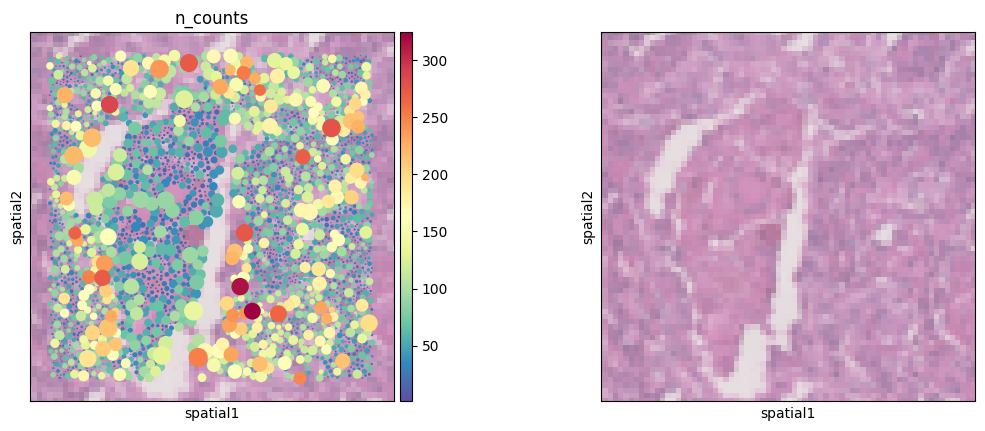

In [24]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.05  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


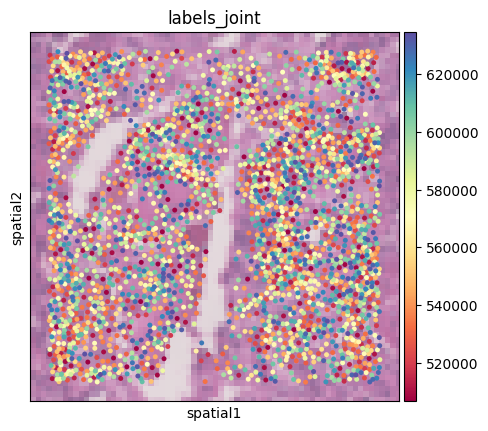

In [26]:
# plot each cell with a different color
adata_cropped.obs['labels_joint'] = adata_cropped.obs.index.astype('int')
# adata_cropped.obs['labels_joint'] = adata_cropped.obs['labels_joint'].astype('category')

sc.pl.spatial(
    adata_cropped,
    color='labels_joint', 
    size=1,
    cmap='Spectral',
    alpha_img=.7,
    spot_size=22,
    show=True,
    # cmap='Set2'
)

plt.show()

In [27]:
# adata_cropped.write(f'../results/intermediate/{sample_id}/cropped_{str(crop_axis_fraction)}_for_spatial_clustering.h5ad')
# file_path = f'../results/intermediate/{sample_id}/cropped_{str(crop_axis_fraction)}_for_spatial_clustering.h5ad'
# adata_cropped = sc.read_h5ad(file_path)
# adata_cropped


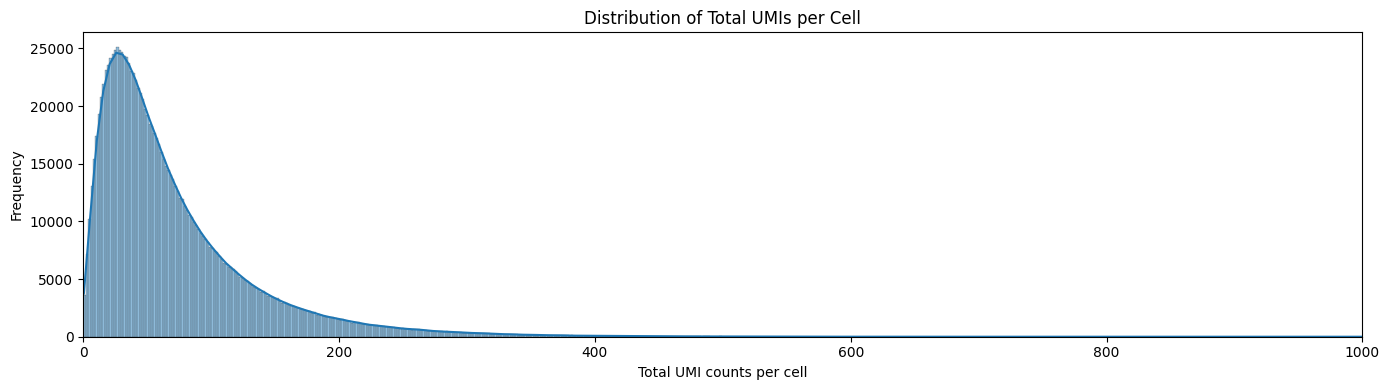

In [28]:
#Visualize the UMI (total counts)
#distribution per cell and the expression distributions of specific marker genes

adata_cells.obs['total_counts'] = np.array(adata_cells.X.sum(axis=1)).flatten()
adata_cells.obs['n_genes_by_counts'] = np.array((adata_cells.X > 0).sum(axis=1)).flatten()
adata_cells.obs

plt.figure(figsize=(14, 4))
sns.histplot(adata_cells.obs['total_counts'], bins=555, kde=True)
plt.xlabel("Total UMI counts per cell")
plt.ylabel("Frequency")
plt.title("Distribution of Total UMIs per Cell")
plt.xlim(0, 1000)  # limit x-axis
plt.tight_layout()
plt.show()



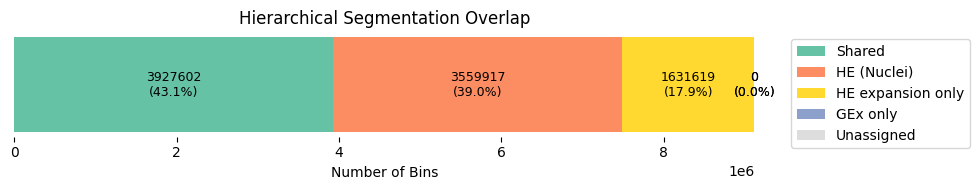

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Boolean masks from adata
is_he = adata_filtered.obs['labels_he'] != 0
is_he_exp = adata_filtered.obs['labels_he_expanded'] != 0
is_gex = adata_filtered.obs['labels_gex'] != 0

# Hierarchical categorization
conditions = {
    "Shared": is_he_exp & is_gex,
    "HE (Nuclei) ": is_he & ~is_gex,
    "HE expansion only": is_he_exp & ~is_gex & ~is_he,
    "GEx only": is_gex & ~is_he_exp,
    "Unassigned": ~is_he_exp & ~is_gex
}

# Count bins in each category
counts = {k: v.sum() for k, v in conditions.items()}

# Create DataFrame
df = pd.DataFrame(list(counts.items()), columns=["Category", "Count"])
df["Percentage"] = df["Count"] / df["Count"].sum() * 100

# Ensure specific order
df["Category"] = pd.Categorical(df["Category"], categories=[
    "Shared", "HE (Nuclei) ", "HE expansion only", "GEx only", "Unassigned"
], ordered=True)
df = df.sort_values("Category")

# Define custom colors
colors = {
    "Shared": "#66c2a5",
    "HE (Nuclei) ": "#fc8d62",
    "HE expansion only": "#ffd92f",
    "GEx only": "#8da0cb",
    "Unassigned": "#dddddd"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
left = 0
for _, row in df.iterrows():
    ax.barh(y=0, width=row["Count"], left=left,
            color=colors[row["Category"]], label=row["Category"])
    ax.text(left + row["Count"]/2, 0,
            f"{int(row['Count'])}\n({row['Percentage']:.1f}%)",
            ha="center", va="center", fontsize=9, color="black")
    left += row["Count"]

ax.set_yticks([])
ax.set_xlabel("Number of Bins")
ax.set_title("Hierarchical Segmentation Overlap")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## Full image vizualisation

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define conditions
# conditions = {
#     "Shared": is_he_exp & is_gex,
#     "HE (no expanded)": is_he & ~is_gex,
#     "HE expansion only": is_he_exp & ~is_gex & ~is_he,
#     "GEx only": is_gex & ~is_he_exp,
#     "Unassigned": ~is_he_exp & ~is_gex
# }

# # Assign Segmentation_Category to adata
# segmentation_category = pd.Series("Unassigned", index=adata_filtered.obs_names)
# for label, mask in conditions.items():
#     segmentation_category[mask] = label
# adata_filtered.obs["Segmentation_Category"] = segmentation_category

# # Define consistent category order and color palette
# category_order = ["Shared", "HE (no expanded)", "HE expansion only", "GEx only", "Unassigned"]
# category_colors = {
#     "Shared": "red",
#     "HE (no expanded)": "lime",
#     "HE expansion only": "darkgreen",
#     "GEx only": "blue",
#     "Unassigned": "white"
# }

# # Extract coordinates and segmentation category
# coords = adata_filtered.obsm["spatial"]
# categories = adata_filtered.obs["Segmentation_Category"]

# # Build dataframe for plotting
# plot_df = pd.DataFrame({
#     "x": coords[:, 0],
#     "y": coords[:, 1],
#     "Category": categories
# })

# # Plot 1: Full Slide
# plt.figure(figsize=(22, 22), dpi=100)
# sns.scatterplot(data=plot_df, x="x", y="y", hue="Category", palette=category_colors, s=3, linewidth=0, alpha=0.9)
# plt.title("Segmentation Categories - Full Slide")
# plt.gca().invert_yaxis()
# plt.gca().set_aspect('equal')
# plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
# plt.tight_layout()
# plt.show()


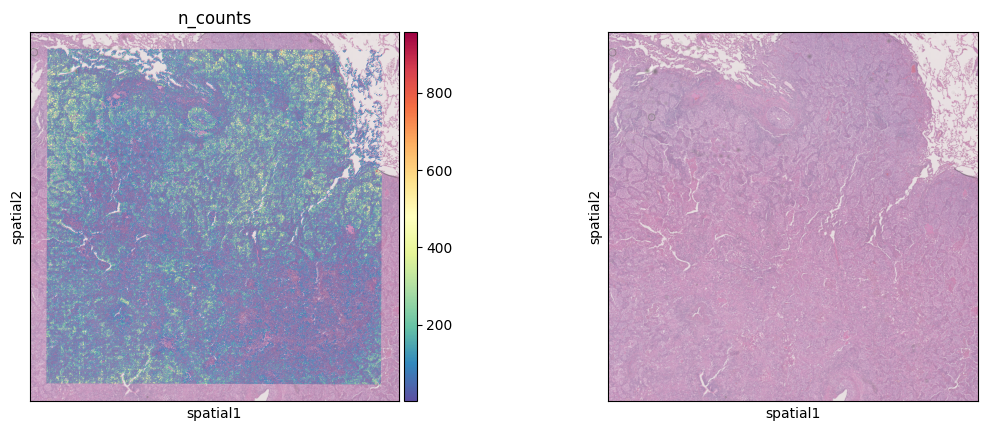

In [30]:

sizes = adata_cells.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cells,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)

In [ ]:
# adata_cells.write(f'../results/intermediate/{sample_id}/adata_cells.h5ad')
# os.makedirs('../results/intermediate/{sample_id}/', exist_ok = True) 

# file_path = f'../results/intermediate/{sample_id}/adata_cells.h5ad'
# # adata_cells = sc.read_h5ad(file_path)
# # adata_cells


# QC and Normalization with BANKSY

In [31]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

import scipy.sparse
if not scipy.sparse.issparse(adata_cells.X):
    print('converting to sparse')
    adata_cells.X = scipy.sparse.csr_matrix(adata_cells.X)
    # adata.raw = adata.X
display_adata(adata_cells)


Displaying adata Object and their attributes
Adata attributes and dimensions:


AnnData object with n_obs × n_vars = 1171054 × 18270
    obs: 'n_counts', 'n_bins', 'total_counts', 'n_genes_by_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

Matrix sparsity: 52457670 filled elements (0.00) out of 21395156580
max: 357.11712346750824, min: 0.1919432391957526

Displaying observations (adata.obs)


,n_counts,n_bins,total_counts,n_genes_by_counts
10000,133.0,20,192.348522,119
100000,24.0,4,40.001328,23
1000000,2.0,2,5.525349,2
1000001,35.0,10,55.902019,35
1000002,28.0,6,56.108157,28
...,...,...,...,...
999995,38.0,9,89.808076,34
999996,13.0,4,32.446331,13
999997,25.0,5,42.871807,25
999998,12.0,4,15.701495,12


Displaying variables (adata.var)


,gene_ids,feature_types,genome,n_cells
OR4F5,ENSG00000186092,Gene Expression,GRCh38,30
SAMD11,ENSG00000187634,Gene Expression,GRCh38,138
NOC2L,ENSG00000188976,Gene Expression,GRCh38,1061
KLHL17,ENSG00000187961,Gene Expression,GRCh38,709
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,592
...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,341254
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,442870
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,60171
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,110325


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


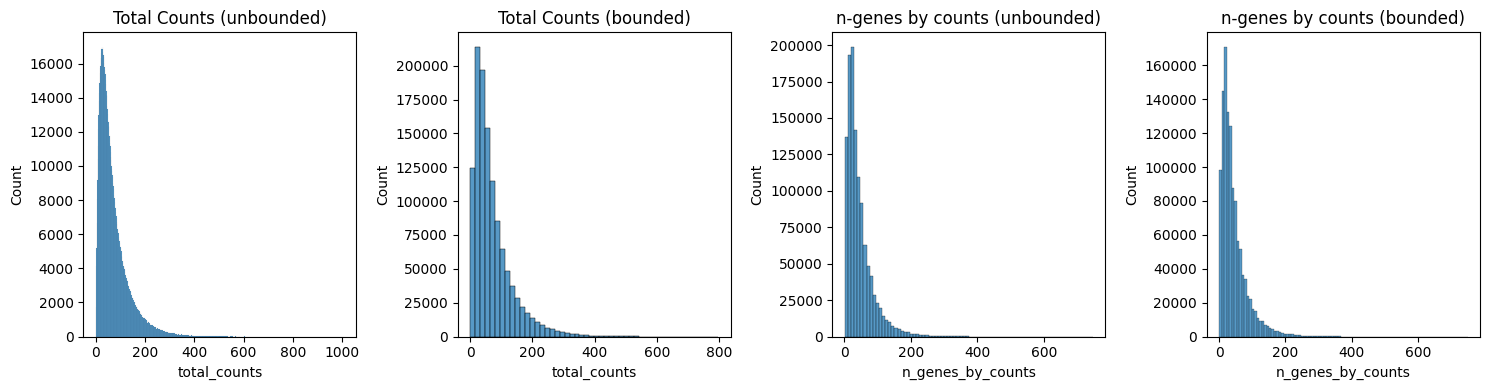

In [32]:
# QC
adata_cells.var_names_make_unique()
adata_cells.var["mt"] = adata_cells.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata_cells, 
                           qc_vars=["mt"], 
                           log1p=True, 
                           inplace=True)

# bin options for fomratting histograms
# Here, we set 'auto' for 1st figure, 80 bins for 2nd figure. and so on
hist_bin_options = ['auto', 50, 80, 100]

plot_qc_hist(adata_cells, 
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
         bin_options = hist_bin_options)

Cells before filtering: 1171054

Cells after count filter: 1164724

cells after MT filter: 1132997



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Genes after minimum cells per gene filter: 13187



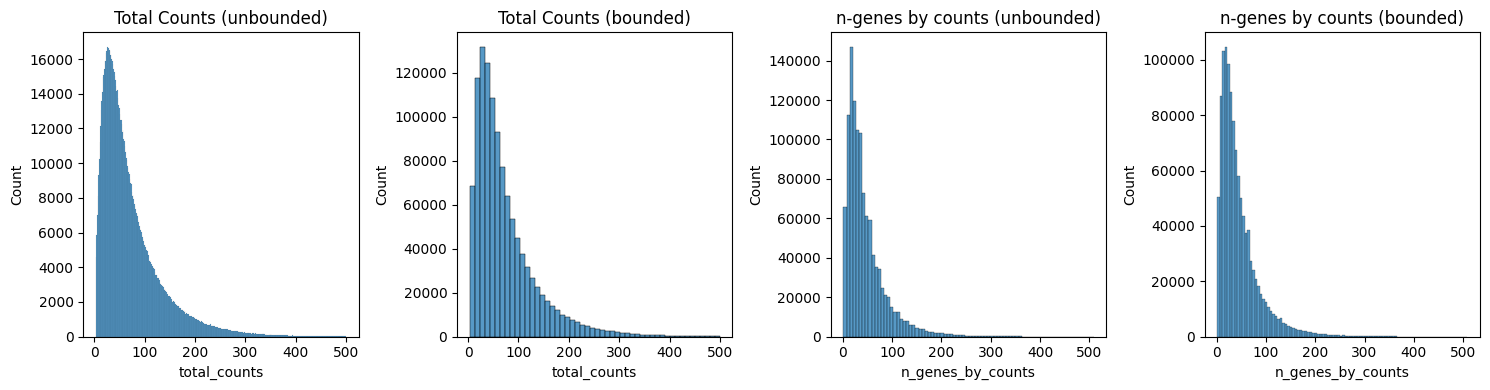

In [36]:
# initial filter of cells by their cell counts, MT count and gene counts
adata_filtred = adata_cells.copy()

adata_filtred = filter_cells(adata_filtred, 
             min_count=3, 
             max_count=500, 
             MT_filter=20, 
             gene_filter=100)

plot_qc_hist(adata_filtred,
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
        bin_options = hist_bin_options)


{'fig_size': (8, 8), 's': 1, 'c1': 'red', 'c2': 'slateblue', 'label1': 'Original adata', 'label2': 'Filtered adata', 'add_circle': False, 'puck_center': (3330, 3180), 'puck_radius': 2550, 'alpha': 0.3}


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


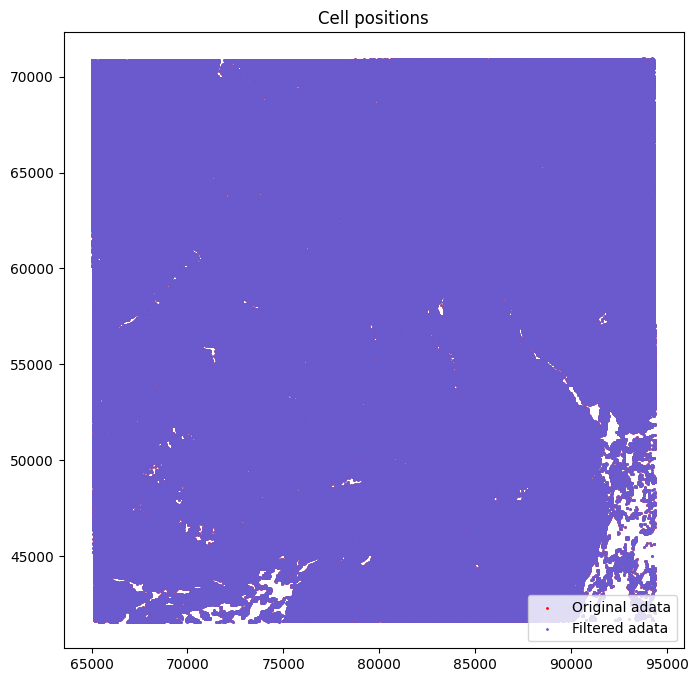

In [37]:
# Convert spatial coordinates to obs columns
adata_filtred.obs['spatial_0'] = adata_filtred.obsm['spatial'][:, 0]
adata_filtred.obs['spatial_1'] = adata_filtred.obsm['spatial'][:, 1]

# Call the plotting function with updated coord_keys
plot_cell_positions(
    adata=adata_filtred,
    raw_x=adata_filtred.obsm['spatial'][:, 0],
    raw_y=adata_filtred.obsm['spatial'][:, 1],
    coord_keys=('spatial_0', 'spatial_1'),
    s=1,
    alpha=.3,
    label1="Original adata",
    label2="Filtered adata"
)
plt.legend()
plt.show()

38057


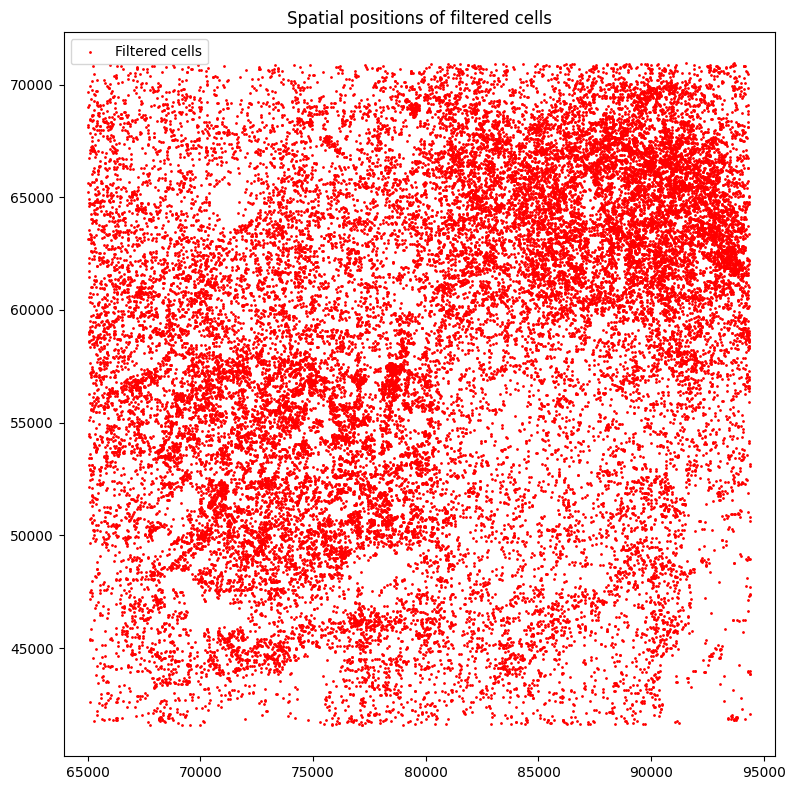

In [38]:
import matplotlib.pyplot as plt

# 1. Get the original and filtered indices
original_indices = set(adata_cells.obs_names)
filtered_indices = set(adata_filtred.obs_names)

# 2. Identify remaining cells (i.e., filtered in)
filtered_out_indices = original_indices - filtered_indices
print(len(filtered_out_indices))

adata_out = adata_cells[list(filtered_out_indices)].copy()

# 4. Add spatial coords to .obs
adata_out.obs['spatial_0'] = adata_out.obsm['spatial'][:, 0]
adata_out.obs['spatial_1'] = adata_out.obsm['spatial'][:, 1]

# 5. Plot
plt.figure(figsize=(8, 8))
plt.scatter(
    adata_out.obs['spatial_0'],
    adata_out.obs['spatial_1'],
    s=1,
    c='red',
    label='Filtered cells'
)
plt.axis("equal")
plt.title("Spatial positions of filtered cells")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
adata_cells

AnnData object with n_obs × n_vars = 1171054 × 18270
    obs: 'n_counts', 'n_bins', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

In [ ]:
# sc.pl.embedding(
#     adata_cells,
#     basis="spatial",
#     color=f'total_counts_mt',
#     size=5,
#     alpha=0.6,
#     show=False
# )

In [40]:
#Identify highly variable genes — modify filter_hvg to skip log1p inside
adata_normalized = adata_filtred.copy()
adata_normalized = normalize_total(adata_normalized)
sc.pp.log1p(adata_normalized)


--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 225.62128194386258, Min: 0.0



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 54.196463163371064, Min: 0.0



In [41]:
sc.pp.highly_variable_genes(
    adata_normalized,
    n_top_genes=2000,    # Or adapt as 
    flavor='seurat',  # or 'cell_ranger' or 'seurat_v3'    
)

adata_normalized = adata_normalized[:, adata_normalized.var['highly_variable']]

display_adata(adata_normalized)

Displaying adata Object and their attributes
Adata attributes and dimensions:


View of AnnData object with n_obs × n_vars = 1132997 × 2000
    obs: 'n_counts', 'n_bins', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'spatial_0', 'spatial_1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg'
    obsm: 'spatial'

Matrix sparsity: 8218490 filled elements (0.00) out of 2265994000
max: 4.010898878102943, min: 0.034920752311661044

Displaying observations (adata.obs)


,n_counts,n_bins,total_counts,n_genes_by_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,spatial_0,spatial_1
10000,192.348522,20,192.348522,119,4.787492,5.264494,56.523562,90.071748,100.0,100.0,14.664284,2.751383,7.623809,68427.131608,47928.485341
100000,40.001328,4,40.001328,23,3.178054,3.713604,100.000000,100.000000,100.0,100.0,2.031250,1.108975,5.077956,67685.941927,46056.606157
1000000,5.525349,2,5.525349,2,1.098612,1.875694,100.000000,100.000000,100.0,100.0,0.000000,0.000000,0.000000,77698.848083,64961.105032
1000001,55.902019,10,55.902019,35,3.583519,4.041331,100.000000,100.000000,100.0,100.0,2.449376,1.238193,4.381551,83990.639765,66926.937012
1000002,56.108157,6,56.108157,28,3.367296,4.044947,100.000000,100.000000,100.0,100.0,5.679352,1.899021,10.122151,80286.916416,68865.959621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,89.808076,9,89.808076,34,3.555348,4.508748,100.000000,100.000000,100.0,100.0,5.262515,1.834582,5.859734,79975.709726,67009.494607
999996,32.446331,4,32.446331,13,2.639057,3.509942,100.000000,100.000000,100.0,100.0,1.465686,0.902470,4.517264,78517.055423,67303.218895
999997,42.871807,5,42.871807,25,3.258097,3.781272,100.000000,100.000000,100.0,100.0,3.911369,1.591553,9.123407,83215.249689,63360.603923
999998,15.701495,4,15.701495,12,2.564949,2.815498,100.000000,100.000000,100.0,100.0,2.832164,1.343430,18.037543,81725.916723,68774.765778


Displaying variables (adata.var)


,gene_ids,feature_types,genome,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
SAMD11,ENSG00000187634,Gene Expression,GRCh38,128,False,130,0.000155,0.000155,99.988899,1.818254e+02,5.208531,True,0.000138,1.195540,1.143997
HES4,ENSG00000188290,Gene Expression,GRCh38,1436,False,1461,0.001770,0.001768,99.875241,2.072405e+03,7.636947,True,0.001339,1.161662,0.970628
C1orf159,ENSG00000131591,Gene Expression,GRCh38,381,False,389,0.000489,0.000489,99.966782,5.727261e+02,6.352152,True,0.000402,1.420388,2.294660
C1QTNF12,ENSG00000184163,Gene Expression,GRCh38,122,False,124,0.000152,0.000152,99.989411,1.777106e+02,5.185768,True,0.000141,1.358719,1.979070
TAS1R3,ENSG00000169962,Gene Expression,GRCh38,165,False,166,0.000206,0.000205,99.985825,2.406720e+02,5.487581,True,0.000195,1.494827,2.675599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC4,ENSG00000182712,Gene Expression,GRCh38,3572,False,3625,0.004416,0.004406,99.690450,5.171528e+03,8.551117,True,0.003591,1.220632,1.272408
MTCP1,ENSG00000214827,Gene Expression,GRCh38,248,False,250,0.000302,0.000302,99.978652,3.536721e+02,5.871194,True,0.000252,1.227979,1.310003
IL9R,ENSG00000124334,Gene Expression,GRCh38,185,False,186,0.000240,0.000240,99.984117,2.814666e+02,5.643560,True,0.000218,1.177271,1.050506
DDX3Y,ENSG00000067048,Gene Expression,GRCh38,4332,False,4385,0.005467,0.005452,99.625551,6.402445e+03,8.764591,True,0.004368,1.186649,1.098500


# Non-Spatial Clustering

In [ ]:
sc.tl.pca(adata_normalized, svd_solver='arpack',n_comps=100)
# “elbow” — the point where additional PCs contribute little variance — and use that number in n_pcs.
sc.pl.pca_variance_ratio(adata_normalized, log=True, n_pcs=100)

In [ ]:
import scanpy as sc


# Parameters
NNei = 15
res = 1
nPCs = 20


# 1. Compute neighborhood graph
sc.pp.neighbors(adata_normalized, n_neighbors=NNei, n_pcs=nPCs)

print(f'Clustering with resolution = {res}')
# 2. Run Leiden clustering
leiden_key = f'nn_{NNei} leiden_{res}'
sc.tl.leiden(
    adata_normalized,
    resolution=res,
    key_added=leiden_key,
)
print(f'Clustering done, ploting...')

sc.pl.embedding(
    adata_normalized,
    basis="spatial",
    color=f'nn_{NNei} leiden_{res}',
    size=5,
    alpha=0.6,
    title=f"Spatial clusters (Leiden res={res})",
    show=False
)
plt.gca().invert_yaxis()
plt.show()

print(f'Generating UMAP for resolution = {res}')

# 3. Compute UMAP embedding
sc.tl.umap(adata_normalized)

print(f'UMAP done, ploting...')

# 5. Plot UMAP colored by clustering result
sc.pl.umap(
    adata_normalized,
    color=leiden_key,
    title=f'nn_{NNei} Leiden {res}',
    size=10  # adjust based on dataset
)



## Manual annotation

In [ ]:
# Load annotation table from xlsx
from collections import defaultdict

file_path = "/scratch/Projects/IMMUNEX/data/annotations/Table_lung_sc.xlsx"
df = pd.read_excel(file_path)

# Group markers per cell type into a list for Lung tissue
lung_df = df[df['Tissue Type'] == 'Lung']
lung_df = lung_df[['Cell name', 'Cell marker']].dropna()

# Group by cell name and aggregate markers into lists
grouped_marker_dict = (
    lung_df.groupby('Cell name')['Cell marker']
    .apply(lambda markers: sorted(set(markers)))  # unique & sorted
    .to_dict()
)

grouped_marker_dict_sample = dict(list(grouped_marker_dict.items())[:10])
grouped_marker_dict_sample



In [ ]:
cluster_key = f'nn_{NNei} leiden_{res}' 

# Score each cell with the marker genes
print("Scoring cells with marker genes...")
for cell_type, markers in tqdm(marker_dict.items()):
    # Filter valid markers that exist in the dataset
    valid_markers = [gene for gene in markers if gene in adata_normalized.var_names]
    if valid_markers:  # only if non-empty
        sc.tl.score_genes(adata_normalized, gene_list=valid_markers, score_name=f'{cell_type}', use_raw=False)
    else:
        print(f"⚠️ No valid markers found for {cell_type}!")

# Check which score columns exist
scored_cell_types = [ct for ct in marker_dict if f'{ct}' in adata_normalized.obs.columns]

# Average scores per Leiden cluster
print("Calculating average scores per cluster...")
cluster_scores = adata_normalized.obs.groupby(cluster_key)[[f'{ct}' for ct in scored_cell_types]].mean()

# Heatmap of scores per cluster
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_scores.T, cmap='viridis')
plt.title("Average Marker Scores per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Automatically assign each cluster to its most likely cell type
print("Assigning dominant cell type per cluster...")
cluster_annotation = cluster_scores.idxmax(axis=1)
cluster_annotation.name = 'manual_annotation'
adata_normalized.obs = adata_normalized.obs.join(cluster_annotation, on=cluster_key)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

leiden_key = f'nn_{NNei} leiden_{res}'

df = pd.DataFrame(adata_normalized.obsm["spatial"], columns=["x", "y"])
df[leiden_key] = adata_normalized.obs[leiden_key].values

# Optional: flip y for image-style orientation
df["y"] = -df["y"]

# Plot: one facet per cluster
g = sns.FacetGrid(df, col=leiden_key, col_wrap=5, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=3, color="blue")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("x", "y")
plt.tight_layout()
plt.show()


In [ ]:
sc.pl.umap(adata_normalized, color=f'manual_annotation', title=f'nn_{NNei} Leiden {res}')

In [ ]:
key = 'manual_annotation'

df = pd.DataFrame(adata_normalized.obsm["spatial"], columns=["x", "y"])
df[key] = adata_normalized.obs[key].values
df["y"] = -df["y"]

g = sns.FacetGrid(df, col=key, col_wrap=5, height=8, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=2, color="black")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("x", "y")
plt.tight_layout()
plt.show()


In [ ]:
sc.pl.spatial(
    adata_normalized, 
    color="manual_annotation", 
    img_key="hires", 
    alpha_img=0.1,
    spot_size=50,
    alpha=1,
    show=True
)

sc.pl.spatial(
    adata_normalized, 
    color="manual_annotation", 
    img_key="hires", 
    alpha_img=1,
    spot_size=1,
    alpha=1,
    show=True
)

# Spatial Clustering

In [42]:
adata_normalized, adata_allgenes = filter_hvg(
    adata_normalized,
    n_top_genes=1000,
    flavor="seurat"
)

--- Normalized and log-transformed data -----
Displaying max and min of Dataset
Max: 1.6116153157905213, Min: 0.0

Displaying dataset after filtering by HVG
View of AnnData object with n_obs × n_vars = 1132997 × 1000
    obs: 'n_counts', 'n_bins', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'spatial_0', 'spatial_1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg'
    obsm: 'spatial'


In [43]:
from banksy.main import median_dist_to_nearest_neighbour

# set params
# ==========
plot_graph_weights = True
k_geom = 7 # only for fixed type
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"
coord_keys=('spatial_0', 'spatial_1','spatial')

# # Find median distance to closest neighbours, the median distance will be `sigma`
# nbrs = median_dist_to_nearest_neighbour(adata, key = coord_keys[2])

In [44]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata_normalized,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=False,
    plt_nbr_weights=False,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=False,
)


Median distance to closest cell = 18.95416346014241

---- Ran median_dist_to_nearest_neighbour in 4.81 s ----

---- Ran generate_spatial_distance_graph in 6.64 s ----

---- Ran row_normalize in 2.57 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 23.19 s ----

---- Ran generate_spatial_distance_graph in 9.34 s ----

---- Ran theta_from_spatial_graph in 9.42 s ----

---- Ran row_normalize in 2.70 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 36.09 s ----



In [45]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
resolutions = [1] # clustering resolution for UMAP
pca_dims = [12] # 25: default # Dimensionality in which PCA reduces to
lambda_list = [0.2] # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata_normalized, banksy_dict, lambda_list, max_m)

Runtime Jul-09-2025-14-26

1000 genes to be analysed:
Gene List:
Index(['SAMD11', 'C1orf159', 'C1QTNF12', 'TAS1R3', 'TMEM240', 'FNDC10',
       'CDK11A', 'PRXL2B', 'PRDM16', 'TP73',
       ...
       'TCEAL7', 'ZCCHC18', 'SMIM10', 'FHL1', 'ZFP92', 'BGN', 'SLC6A8',
       'MTCP1', 'IL9R', 'MT-CO3'],
      dtype='object', length=1000)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7930979 stored elements and shape (1132997, 1132997)>, 1: <Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 15861958 stored elements and shape (1132997, 1132997)>}}

Nbr matrix | Mean: 0.0 | Std: 0.06
Size of Nbr | Shape: (1132997, 1000)
Top 3 entries of Nbr Mat:

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

AGF matrix | Mean: 0.0 | Std: 0.02
Size of AGF mat (m = 1) | Shape: (1132997, 1000)
Top entries of AGF:
[[0.02096726 0.         0.        ]
 [0.         0.         0.        ]

In [ ]:
# from banksy.main import concatenate_all

# banksy_dict["nonspatial"] = {
#     # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
#     0.0: {"adata": concatenate_all([adata_normalized.X], 0, adata=adata_normalized), }
# }

# print(banksy_dict['nonspatial'][0.0]['adata'])

In [46]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

Current decay types: ['scaled_gaussian']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 12
Original shape of matrix: (1132997, 3000)
Reduced shape of matrix: (1132997, 12)
------------------------------------------------------------
min_value = -31.520676856644652, mean = 3.087619111293365e-14, max = 121.20604569869532

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_12_umap"]


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP embedding
------------------------------------------------------------
shape: (1132997, 2)


AxisArrays with keys: reduced_pc_12, reduced_pc_12_umap


In [ ]:
from banksy.cluster_methods import run_Leiden_partition
seed = 123

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 25,
    num_iterations = -1,
    partition_seed = seed,
    match_labels = True,
)

In [ ]:
from banksy.plot_banksy import plot_results

c_map =  'rainbow' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
file_path = '../results/intermediate/{sample_id}/'

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(file_path, 'banksy_tmp_png'),
    save_fig = True, # save the spatial map of all clusters
    save_seperate_fig = True, # save the figure of all clusters plotted seperately
)

## Annotate Banksy

In [ ]:
adata_banksy = banksy_dict['scaled_gaussian'][0.2]['adata'].copy()
adata_banksy.obs['labels_scaled_gaussian_pc25_nc0.20_r0.70']
adata_banksy

In [ ]:
# Load annotation table from xlsx
from collections import defaultdict

file_path = "/scratch/Projects/IMMUNEX/data/annotations/Table_lung_sc.xlsx"
Table_lung_sc = pd.read_excel(file_path)
display(Table_lung_sc.head())

# Group markers per cell type into a list for Lung tissue
lung_df = Table_lung_sc[Table_lung_sc['Tissue Type'] == 'Lung']
lung_df = Table_lung_sc[Table_lung_sc['Species'] == 'Human']
lung_df = Table_lung_sc[Table_lung_sc['Supports'] > 1]
lung_df.loc[lung_df['Cell name'] == 'Club cell (Clara cell)' ,'Cell name'] = 'Clara cell'

lung_df = lung_df[['Cell name', 'Cell marker']].dropna()

# Group by cell name and aggregate markers into sorted unique string lists
grouped_marker_dict = (
    lung_df.groupby('Cell name')['Cell marker']
    .apply(lambda markers: sorted(set(str(m) for m in markers)))  # Convert all to strings
    .to_dict()
)

# Limit to first 10 entries for inspection
marker_dict = dict(list(grouped_marker_dict.items()))

print(marker_dict.keys()) 

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Clean the marker_dict to include only genes present in adata_banksy
cleaned_marker_dict = {}
missing_genes = {}

for cell_type, genes in marker_dict.items():
    valid_genes = [g for g in genes if g in adata_banksy.var_names]
    if valid_genes:
        cleaned_marker_dict[cell_type] = valid_genes
    else:
        print(f"⚠️ No valid genes found for {cell_type}")
    missing = [g for g in genes if g not in adata_banksy.var_names]
    if missing:
        missing_genes[cell_type] = missing

# Optional: print all missing genes
print("Missing genes:")
for ct, genes in missing_genes.items():
    print(f"{ct}: {genes}")

# Step 2: Plot matrixplot with cleaned markers
sc.pl.matrixplot(
    adata_banksy,
    var_names=cleaned_marker_dict,
    groupby='labels_scaled_gaussian_pc25_nc0.20_r0.70',
    use_raw=False,
    cmap='RdYlBu_r',
    standard_scale='var',
    dendrogram=True,
    colorbar_title='Z-score',
    figsize=(30, 12)
)




In [ ]:
import scanpy as sc
import pandas as pd

# === Step 0: Inputs ===
adata = adata_banksy  # or adata_norm
cluster_key = 'labels_scaled_gaussian_pc25_nc0.20_r0.70'  # adjust for your cluster key

# === Step 1: Clean marker dict to only include genes in adata ===
cleaned_marker_dict = {
    cell_type: [g for g in genes if g in adata.var_names]
    for cell_type, genes in marker_dict.items()
}
# Remove empty entries
cleaned_marker_dict = {k: v for k, v in cleaned_marker_dict.items() if v}

# === Step 2: Extract expression + cluster info ===
all_genes = [g for genes in cleaned_marker_dict.values() for g in genes]
df_expr = sc.get.obs_df(adata, keys=all_genes + [cluster_key])

# === Step 3: Compute mean expression of each gene per cluster ===
cluster_means = df_expr.groupby(cluster_key).mean().T  # genes as rows, clusters as columns

# === Step 4: Z-score across clusters (per gene) ===
zscore_matrix = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# === Step 5: Compute mean Z-score per cluster per cell type ===
celltype_scores = pd.DataFrame(index=cleaned_marker_dict.keys(), columns=zscore_matrix.columns)

for celltype, genes in cleaned_marker_dict.items():
    celltype_scores.loc[celltype] = zscore_matrix.loc[genes].mean(axis=0)

celltype_scores = celltype_scores.astype(float)

# === Step 6: Assign each cluster to the cell type with the highest score ===
cluster_to_celltype = celltype_scores.idxmax()

# === Step 7: Convert to dictionary ===
cluster_to_celltype_dict = cluster_to_celltype.to_dict()

# Optional: display result
print("Cluster to Cell Type Mapping:")
for cluster, celltype in cluster_to_celltype_dict.items():
    print(f"Cluster {cluster}: {celltype}")


In [ ]:
import scanpy as sc
import pandas as pd

# Reuse previous results
# cluster_key = 'labels_scaled_gaussian_pc25_nc0.20_r0.70'
# cluster_to_celltype_dict = { ... }  # From previous step

# === Step 1: Add cell type annotation column to adata_banksy ===
adata_banksy.obs['semiautomatic_annotation'] = (
    adata_banksy.obs[cluster_key].astype(str).map(cluster_to_celltype_dict)
)

# Optional: check for unmapped clusters
unmapped = adata_banksy.obs['semiautomatic_annotation'].isna().sum()
if unmapped > 0:
    print(f"⚠️ Warning: {unmapped} cells could not be mapped to a cell type.")

# === Step 2: Plot spatial embedding colored by inferred cell type ===
sc.pl.spatial(
    adata_banksy,
    size=10,
    color='semiautomatic_annotation',
    spot_size=20,  # adjust depending on resolution
    palette='rainbow_r',
)


In [ ]:
import scanpy as sc

# Set global figure size parameters
sc.set_figure_params(figsize=(30, 30))  # Or any desired size

# Then plot spatial embedding
sc.pl.spatial(
    adata_banksy,
    size=10,  # Size of points in matplotlib units
    color='semiautomatic_annotation',
    spot_size=8,  # Adjust as needed
    palette='rainbow_r'
)


In [ ]:
sc.set_figure_params(figsize=(12, 6))  # Or any desired size

df_counts = pd.DataFrame(adata_banksy.obs['semiautomatic_annotation'].value_counts(normalize=True).reset_index())

sns.barplot(data=df_counts, y='index', x='semiautomatic_annotation', palette='rainbow_r')
plt.title(f'Cell Type Abundance ({key_name})')
plt.tight_layout()
plt.show()